<b><font size="4"> Capstone Project - The Battle of the Neighborhoods </font><b>


<b><font size="5">Introduction: Business Problem </font><b>
    
 Openning a Persian restaurant in Toronto   
 

<b><font size="4">Background </font><b>
    
My brother is going to open either restaurant or a cafe in Toronto. He asked my idea of which one could be a better idea and of a good location for running a restaurant or a cafe.Also He'd like to have Persian food in his restaurant.So, I decided to prepare some data in order to answer his questions.In this report I am trying to help him to target optimal places in Toronto for openning a persian restaurant or a cafe.
Prior launching any restaurant, it’s important to know if the business is a good opportunity. In order to do so, this report will try to gather data about other restaurants and cafe and their localization, competitors and accessibility by maximum number of people.

<b><font size="5">Data</font><b>

For this problem, we will get the services of Foursquare API to explore the data of the city, in terms of the neighborhoods. The data also include the information about the places around each neighborhood like restaurants and coffee shops,
I selected Downtown Toronto, I will be using a bit of  machine learning technique, “Clustering” to segment the neighborhoods with similar objects on the basis of each neighborhood data.

Following data sources will be needed to extract/generate the required information:


Wikipedia: to find Toronto neighbourhood,borough,population
https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1012118802

Statistic Canada: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/File.cfm?T=1201&SR=1&RPP=9999&PR=0&CMA=0&CSD=0&S=22&O=A&Lang=Eng&OFT=CSV'

Geopy: to getting the co-ordinated of different locations.

Foursquare API: To get the restaurant venues and their details in every neighbourhood.
https://api.foursquare.com


Combining all of these data sets will clearly demonstrate the following:
<ul>
<li>which neighborhoods in Toronto have clusters of like Restaurants.</li>
<li>how populated each neighborhoods is.</li>
<li>which neighborhood should he target to open his new store.</li>
</ul>

<b><font size="5">Methodology</font><b>

<ul>
<li>Getting the co-ordinates of the city downtown.</li>
<li>Getting the list of neighborhoods and their co-ordinates.</li>
<li>Clustering the localities.</li>
<li>Analyzing the clusters.</li>
<li>Collecting information about the type of restaurants already present in a locality including Persian venues.</li>
<li>Creating a machine learning model based on data.</li>
</ul>

<b>Target audience<b>

<ul>
<li>These data could be used by a business entrepreneur that wants to open a new restaurant in Toronto. </li>
 
<li>Business Analyst or Data Scientists, who wish to analyze the neighborhoods of Toronto using python, Jupiter notebook and some machine learning techniques.</li>
</ul>

First we install some Python packages:

In [1]:
!pip install wikipedia
!pip install folium
!pip install geopandas
!pip install geojson

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


 <b><font size="4">Toronto neighborhoods broken down by postal code.</font><b>

In [277]:
# Find the table using beautifulsoup and using Pandas to read it

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import pandas as pd 
import lxml

website_url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1012118802"

response = requests.get(website_url)

soup = BeautifulSoup(response.content,"lxml")

table = soup.find("table",attrs={"class":"wikitable"})

df = pd.read_html(str(table))

# Convert the list back into a dataframe
df = pd.DataFrame(df[0])


# Removing rows that has 'Not assigned' values either in"Borough" or Neighbourhood columnprint(table)  

df1 = df[~((df['Borough'] == 'Not assigned') | (df['Neighbourhood'] == 'Not assigned'))].reset_index()
                   
df1.head()

,index,Postal Code,Borough,Neighbourhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [278]:
# Rename the columns as instructed
df1 = df1.rename(columns={'Neighbourhood':'Neighborhood'})

In [279]:
#Combine rows into one row which PostalCode and Borough as same value into one row and seperate them with comma
df2 = df1.groupby(['Postal Code', 'Borough'])['Neighborhood'].apply(','.join).reset_index()
df2.index = df2.index +1
df2.head()

,Postal Code,Borough,Neighborhood
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae


In [280]:
# Load Toronto geospatial cooridinates

lat_lng = pd.read_csv('https://cocl.us/Geospatial_data')

# adjust the column name with the first dataset

lat_lng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [464]:
# Merging the two tables to get the Latitudes and Longitudes for neighbourhoods 

df3 = pd.merge(df2 , lat_lng ,how="left", on ="Postal Code")
df3.index = df3.index +1
df3.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
1,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
3,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
4,M1G,Scarborough,Woburn,43.770992,-79.216917
5,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


 <b><font size="3">Getting Toronto Population based on Postal Codes</font><b>

In [282]:
# Load this data from Statistic Canada
df_pop = pd.read_csv('https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/File.cfm?T=1201&SR=1&RPP=9999&PR=0&CMA=0&CSD=0&S=22&O=A&Lang=Eng&OFT=CSV',encoding = 'unicode_escape')

# Rename the columns appropiatley
df_pop = df_pop.rename(columns={'Geographic code':'PostalCode', 'Geographic name':'PostalCod2', 'Province or territory':'Province', 'Incompletely enumerated Indian reserves and Indian settlements, 2016':'Incomplete', 'Population, 2016':'Population_2016', 'Total private dwellings, 2016':'TotalPrivDwellings', 'Private dwellings occupied by usual residents, 2016':'PrivDwellingsOccupied'})
df_pop= df_pop.drop(columns=['PostalCod2', 'Province', 'Incomplete', 'TotalPrivDwellings', 'PrivDwellingsOccupied'])
# Removing the first row 
df_pop = df_pop.iloc[1:]
#rename the coloumns so the match
df_pop = df_pop.rename(columns={'PostalCode':'Postal Code','Population_2016':'Population'})

df_pop.head()

,Postal Code,Population
1,A0A,46587.0
2,A0B,19792.0
3,A0C,12587.0
4,A0E,22294.0
5,A0G,35266.0


 <b><font size="3">Merge Toronto Neighbourhood populations data with Toronto Postal Code data</font><b>

In [462]:
# we merge the population with geopostal code and sort the data on ascending poulation.

import pandas as pd

df4 = pd.merge(df_pop, df3, on= "Postal Code", how='right')
df4 = df4.sort_values(by=['Population'],ascending=False)

df4.head()

,Postal Code,Population,Borough,Neighborhood,Latitude,Longitude
22,M2N,75897.0,North York,"Willowdale, Willowdale East",43.770120,-79.408493
0,M1B,66108.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
18,M2J,58293.0,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
100,M9V,55959.0,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
14,M1V,54680.0,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577


In [467]:
address = 'Downtown, Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of downtown Toronto are 43.6541737, -79.38081164513409.


In [509]:
#A map of downtown Toronto with centroids of every neighborhood:
map_To = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for lat, lng, borough, neighborhood in zip(df4['Latitude'], 
                                           df4['Longitude'], 
                                           df4['Population'],
                                           df4['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3185cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_To)  
    
map_To

 <b><font size="3">Number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API__
Extract venues for each neighborhood in downotown Toronto</font><b>

In [490]:
CLIENT_ID = 'KWIJW2KFBAXJXX432CUOZXZG5KUBA32SZLWJMAERFKMLG1WA'
CLIENT_SECRET = 'KJFZZEMBDEO24TLMFUMHCPP0ZVP2BV252DSWYTK0WAWNQZ3X'
VERSION = '20210418'
LIMIT = 200
radius = 600 
print('Done!')

Done!


In [492]:
#exploring neighborhoods in our dataframe.
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

LIMIT = 200 # limit of number of venues returned by Foursquare API

radius = 600 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [493]:


Toronto_venues = getNearbyVenues(names=df4['Neighborhood'],latitudes=df4['Latitude'],longitudes=df4['Longitude'],radius=1500)                              
                                         
print(Toronto_venues.shape)



Willowdale, Willowdale East
Malvern, Rouge
Fairview, Henry Farm, Oriole
South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens
Milliken, Agincourt North, Steeles East, L'Amoreaux East
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Steeles West, L'Amoreaux West
Kennedy Park, Ionview, East Birchmount Park
Guildwood, Morningside, West Hill
Woodbine Heights
Dorset Park, Wexford Heights, Scarborough Town Centre
Dufferin, Dovercourt Village
Del Ray, Mount Dennis, Keelsdale and Silverthorn
Downsview
Runnymede, The Junction, Weston-Pellam Park, Carlton Village
Regent Park, Harbourfront
Brockton, Parkdale Village, Exhibition Place
Willowdale, Willowdale West
Northwest, West Humber - Clairville
High Park, The Junction South
Don Mills
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Caledonia-Fairbanks
New Toronto, Mimico South, Humber Bay Shores
Agincourt
Bathurst Manor

In [495]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,61,61,61,61,61,61
"Alderwood, Long Branch",42,42,42,42,42,42
"Bathurst Manor, Wilson Heights, Downsview North",40,40,40,40,40,40
Bayview Village,17,17,17,17,17,17
"Bedford Park, Lawrence Manor East",75,75,75,75,75,75
...,...,...,...,...,...,...
"Willowdale, Willowdale West",38,38,38,38,38,38
Woburn,33,33,33,33,33,33
Woodbine Heights,68,68,68,68,68,68


In [289]:
#We'll only select the restaurants and food vnues from Venue Categories

print('Unique Venue Categories:')
list(Toronto_venues['Venue Category'].unique())

Unique Venue Categories:


['Ramen Restaurant',
 'Grocery Store',
 'Seafood Restaurant',
 'Hotel',
 'Café',
 'Coffee Shop',
 'Creperie',
 'Bubble Tea Shop',
 'Japanese Restaurant',
 'Sushi Restaurant',
 'Bakery',
 'Plaza',
 'Theater',
 'Movie Theater',
 'Fried Chicken Joint',
 'Korean Restaurant',
 'Supermarket',
 'Shopping Mall',
 'Lounge',
 'Pizza Place',
 'Ice Cream Shop',
 'Restaurant',
 'Juice Bar',
 'Arts & Crafts Store',
 'Dumpling Restaurant',
 'Burger Joint',
 'Thai Restaurant',
 'Pet Store',
 'Pool',
 'Spa',
 'Fast Food Restaurant',
 'Yoga Studio',
 'Gym',
 'Dessert Shop',
 'Pharmacy',
 'Burrito Place',
 'Poke Place',
 'Diner',
 'Poutine Place',
 'Chinese Restaurant',
 'Beer Store',
 'Wings Joint',
 'Food Stand',
 'Bank',
 'Middle Eastern Restaurant',
 'Smoothie Shop',
 'Udon Restaurant',
 'Vietnamese Restaurant',
 'Sandwich Place',
 'Italian Restaurant',
 'Hardware Store',
 'Hot Dog Joint',
 'Noodle House',
 'Zoo Exhibit',
 'Caribbean Restaurant',
 'Paper / Office Supplies Store',
 'Gas Station',
 'Li

In [290]:
# We'll make a list of restaurants or cafes manually out of unique Venue list.
res_list =  ['Steakhouse', 'Coffee Shop', 'Café', 'Ramen Restaurant', 'Indonesian Restaurant', 'Restaurant', 'Japanese Restaurant', 
             'Fast Food Restaurant', 'Sushi Restaurant', 'Vietnamese Restaurant', 'Pizza Place', 'Sandwich Place', 'Middle Eastern Restaurant', 
             'Burger Joint', 'American Restaurant', 'Food Court', 'Wings Joint', 'Burrito Place', 'Asian Restaurant', 'Deli / Bodega', 
             'Greek Restaurant', 'Fried Chicken Joint', 'Airport Food Court', 'Chinese Restaurant', 'Breakfast Spot', 'Mexican Restaurant',
             'Indian Restaurant', 'Latin American Restaurant', 'Bar', 'Pub', 'Italian Restaurant', 'French Restaurant', 'Ice Cream Shop', 
             'Caribbean Restaurant', 'Gastropub', 'Thai Restaurant', 'Cajun / Creole Restaurant', 'Diner', 'Dim Sum Restaurant', 'Seafood Restaurant', 
             'Food & Drink Shop', 'Noodle House', 'Food', 'Fish & Chips Shop', 'Falafel Restaurant', 'Gourmet Shop', 'Vegetarian / Vegan Restaurant', 
             'South American Restaurant', 'Korean Restaurant', 'Cuban Restaurant', 'New American Restaurant', 'Malay Restaurant', 'Mac & Cheese Joint',
             'Bistro', 'Southern / Soul Food Restaurant', 'Tapas Restaurant',  'Sports Bar', 'Polish Restaurant', 'Ethiopian Restaurant', 
             'Creperie', 'Sake Bar', 'Persian Restaurant', 'Afghan Restaurant','Mediterranean Restaurant', 'BBQ Joint', 'Jewish Restaurant', 
             'Comfort Food Restaurant',  'Hakka Restaurant', 'Food Truck', 'Taiwanese Restaurant',  'Snack Place', 'Eastern European Restaurant', 
             'Dumpling Restaurant', 'Belgian Restaurant', 'Arepa Restaurant', 'Taco Place', 'Doner Restaurant', 'Filipino Restaurant', 
             'Hotpot Restaurant', 'Poutine Place', 'Salad Place',  'Portuguese Restaurant', 'Modern European Restaurant', 'Empanada Restaurant', 
             'Irish Pub', 'Molecular Gastronomy Restaurant', 'German Restaurant', 'Brazilian Restaurant', 'Gluten-free Restaurant', 'Soup Place']



In [292]:
res_pd = pd.DataFrame(res_list)
# rename the coloumns 
res_pd = res_pd.rename(columns={0:'Venue Category'})
#Join the 2 dataframes 
Toronto_new = pd.merge(Toronto_venues, res_pd, on='Venue Category', how='right')

# display the new dataframe
#TO_new

Toronto_new.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,35,35,35,35,35,35
"Alderwood, Long Branch",23,23,23,23,23,23
"Bathurst Manor, Wilson Heights, Downsview North",16,16,16,16,16,16
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",51,51,51,51,51,51
...,...,...,...,...,...,...
"Willowdale, Willowdale West",19,19,19,19,19,19
Woburn,17,17,17,17,17,17
Woodbine Heights,32,32,32,32,32,32


In [293]:
# Merging Toronoto population data with Venue table

pop_df = pd.merge(Toronto_new, df4, on='Neighborhood', how='right')
pop_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal Code,Population,Borough,Latitude,Longitude
0,"Willowdale, Willowdale East",43.77012,-79.408493,Konjiki Ramen,43.766998,-79.412222,Ramen Restaurant,M2N,75897.0,North York,43.77012,-79.408493
1,"Willowdale, Willowdale East",43.77012,-79.408493,Sansotei Ramen 三草亭,43.776709,-79.413927,Ramen Restaurant,M2N,75897.0,North York,43.77012,-79.408493
2,"Willowdale, Willowdale East",43.77012,-79.408493,Hakata Shoryuken Ramen,43.773519,-79.413872,Ramen Restaurant,M2N,75897.0,North York,43.77012,-79.408493
3,"Willowdale, Willowdale East",43.77012,-79.408493,Kenzo Japanese Ramen House,43.762851,-79.411426,Ramen Restaurant,M2N,75897.0,North York,43.77012,-79.408493
4,"Willowdale, Willowdale East",43.77012,-79.408493,The Captain's Boil,43.773255,-79.413805,Seafood Restaurant,M2N,75897.0,North York,43.77012,-79.408493


In [294]:
Toronto_new.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,35,35,35,35,35,35
"Alderwood, Long Branch",23,23,23,23,23,23
"Bathurst Manor, Wilson Heights, Downsview North",16,16,16,16,16,16
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",51,51,51,51,51,51
...,...,...,...,...,...,...
"Willowdale, Willowdale West",19,19,19,19,19,19
Woburn,17,17,17,17,17,17
Woodbine Heights,32,32,32,32,32,32


<b><font size="3">We'll take a look at the number of venues in each neighborhood. Also we'll get the unique number of each venue category 
<b><font size="3">

In [295]:


resDF = Toronto_new.groupby('Neighborhood').size().reset_index(name='Counts') 
resDF.head(10)

,Neighborhood,Counts
0,Agincourt,35
1,"Alderwood, Long Branch",23
2,"Bathurst Manor, Wilson Heights, Downsview North",16
3,Bayview Village,5
4,"Bedford Park, Lawrence Manor East",51
5,Berczy Park,47
6,"Birch Cliff, Cliffside West",6
7,"Brockton, Parkdale Village, Exhibition Place",54
8,"Business reply mail Processing Centre, South C...",57
9,"CN Tower, King and Spadina, Railway Lands, Har...",24


In [296]:
# Let's find out how many unique categories can be curated from all the selected venues
print('There are {} uniques Venue categories in downtown Toronto.'.format(len(pop_df['Venue Category'].unique())))

There are 82 uniques Venue categories in downtown Toronto.


<b><font size="2">let's see the 10 most common venue categories in downtownToronto <b><font size="2">

In [732]:
# take a look at the most common type of venues and their numbers
venue_DF = Toronto_new.groupby('Venue Category').size().reset_index(name='Counts')
venue_DF.sort_values(by=['Counts'], ascending=False).head(10)

,Venue Category,Counts
17,Coffee Shop,559
13,Café,274
65,Pizza Place,209
71,Restaurant,195
50,Italian Restaurant,177
74,Sandwich Place,142
51,Japanese Restaurant,123
82,Sushi Restaurant,98
30,Fast Food Restaurant,95
6,Bar,74


let's get the number of Persian restaurant in downtown Toronto 

In [719]:
#We take a look at the number of Persian restaurant in Toronto
Toronto_new['Venue Category'].value_counts()['Persian Restaurant']

7

Then to analyze the data we performed a technique in which Categorical Data is transformed into Numerical Data for Machine Learning algorithms. This technique is called One hot encoding. For each of the neighbourhoods, individual venues were turned into the frequency at how many of those Venues were located in each neighbourhood.

In [298]:

# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_new[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_new['Neighborhood'] 


# moving neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()
Toronto_onehot.shape

(3623, 91)

let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [299]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.shape

Toronto_grouped.head()

,Neighborhood,Afghan Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bar,Belgian Restaurant,Bistro,...,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Agincourt,0.0,0.0,0.0000,0.0,0.057143,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.028571,0.0,0.0,0.0,0.000000,0.0,0.028571,0.000000
1,"Alderwood, Long Branch",0.0,0.0,0.0000,0.0,0.000000,0.000000,0.086957,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.043478
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0625,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.062500,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,Bayview Village,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0000,0.0,0.039216,0.019608,0.000000,0.0,0.0,...,0.0,0.019608,0.098039,0.0,0.0,0.0,0.019608,0.0,0.000000,0.019608


In [502]:
Toronto_rests_ngh = pd.merge(df4,Toronto_grouped,on='Neighborhood', how='right')
Toronto_rests_ngh.head()

,Postal Code,Population,Borough,Neighborhood,Latitude,Longitude,Afghan Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,...,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,M2N,75897.0,North York,"Willowdale, Willowdale East",43.770120,-79.408493,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.050000,0.0,0.0,0.0,0.016667,0.000000,0.033333,0.016667
1,M1B,66108.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,M2J,58293.0,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,0.0,0.0,0.03125,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.031250,0.000000,0.000000,0.000000
3,M9V,55959.0,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,0.0,0.0,0.00000,0.0,...,0.0,0.043478,0.043478,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,M1V,54680.0,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,0.0,0.0,0.00000,0.0,...,0.0,0.018868,0.000000,0.0,0.0,0.0,0.000000,0.018868,0.056604,0.000000


In [300]:
mean=Toronto_grouped.describe()
mean.reset_index()

,index,Afghan Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bar,Belgian Restaurant,Bistro,...,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,count,98.000000,98.0,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
1,mean,0.000498,0.0,0.012404,0.0,0.013577,0.012016,0.015609,0.000186,0.001089,...,0.004116,0.004965,0.023609,0.001991,0.000784,0.001423,0.016775,0.009451,0.014764,0.006158
2,std,0.004928,0.0,0.023207,0.0,0.030368,0.018578,0.027069,0.001837,0.006119,...,0.016219,0.010435,0.029474,0.006754,0.004959,0.005858,0.023752,0.017032,0.033580,0.015884
3,min,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,50%,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.016393,0.000000,0.000000,0.000000,0.012791,0.000000,0.000000,0.000000
6,75%,0.000000,0.0,0.019371,0.0,0.018868,0.020000,0.023395,0.000000,0.000000,...,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.024245,0.016879,0.018519,0.000000
7,max,0.048780,0.0,0.125000,0.0,0.250000,0.090909,0.114286,0.018182,0.052632,...,0.125000,0.048780,0.114286,0.038462,0.043478,0.035088,0.166667,0.090909,0.228571,0.090909


So we'll try to get the 10 most common venue categories in our Toronto dataset

In [301]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [302]:
top_venues = 10

indicators = ['first', 'second', 'third']

# create columns of top venues
columns = ['Neighborhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Toronto_venues_sorted = pd.DataFrame(columns=columns)
Toronto_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    Toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], top_venues)


In [514]:
Toronto_venues_sorted.head()

,Neighborhood,1first Most Common Venue,2second Most Common Venue,3third Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Coffee Shop,Asian Restaurant,Caribbean Restaurant,Breakfast Spot,Restaurant,Sandwich Place,Seafood Restaurant,Malay Restaurant,Latin American Restaurant
1,"Alderwood, Long Branch",Pizza Place,Café,Burger Joint,Coffee Shop,Bar,Restaurant,Gourmet Shop,Greek Restaurant,Fried Chicken Joint,Italian Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Pizza Place,Sandwich Place,Diner,Middle Eastern Restaurant,Mediterranean Restaurant,Restaurant,Deli / Bodega,Ice Cream Shop,Fried Chicken Joint
3,Bayview Village,Japanese Restaurant,Restaurant,Chinese Restaurant,Café,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sushi Restaurant,Pizza Place,Coffee Shop,Pub,Café,Restaurant,Fast Food Restaurant,Asian Restaurant,Sandwich Place


<b><font size="4"> Clustering
</font><b>
    


<b><font size="4"> check cluster labels generated for each row in the dataframe</font><b>
kmeans.labels_[0:10]

 <b><font size="3">Running K-means and segmening data into clusters to make labels</font><b>
    

    
 we Use silhouette score to find the number of clusters to segment the data
    

In [524]:
#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

Toronto_grouped_cluster = Toronto_grouped.drop('Neighborhood', 1)

# Create cluster column in dataframe and run k-means clustering
kclusters = np.arange(2,10)
results = {}
for size in kclusters:
    model = KMeans(n_clusters = size).fit(Toronto_grouped_cluster)
    predictions = model.predict(Toronto_grouped_cluster)
    results[size] = silhouette_score(Toronto_grouped_cluster, predictions)

best_size = max(results, key=results.get)
best_size

3

In [527]:
# set number of clusters
kclusters = 3

Toronto_grouped_cluster = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 2, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

In [537]:
kmeans.labels_

array([2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2,
       1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 0, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

 <b><font size="3"># merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
 </font><b>

In [691]:
#Add clustering labels

Toronto_venues_sorted.drop(columns=['Cluster Labels'],inplace=True)
Toronto_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)
Toronto_merged = Toronto_venues_sorted

#Toronto_grouped_cluster['Cluster Labels'] = kmeans.labels_

Toronto_merged = pd.merge(df4,Toronto_venues_sorted,on='Neighborhood', how='right')

Toronto_merged.head()


,Postal Code,Population,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1first Most Common Venue,2second Most Common Venue,3third Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2N,75897.0,North York,"Willowdale, Willowdale East",43.770120,-79.408493,1,Korean Restaurant,Coffee Shop,Ramen Restaurant,Pizza Place,Japanese Restaurant,Sushi Restaurant,Café,Vietnamese Restaurant,Sandwich Place,Burger Joint
1,M1B,66108.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1,Pizza Place,Restaurant,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Caribbean Restaurant,Filipino Restaurant,Sandwich Place,Wings Joint,Ethiopian Restaurant
2,M2J,58293.0,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,1,Coffee Shop,Middle Eastern Restaurant,Japanese Restaurant,Pizza Place,Chinese Restaurant,Restaurant,Sandwich Place,Burger Joint,Fried Chicken Joint,Pub
3,M9V,55959.0,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,1,Coffee Shop,Fast Food Restaurant,Pizza Place,Caribbean Restaurant,Sandwich Place,Steakhouse,Burger Joint,Indian Restaurant,Japanese Restaurant,Sushi Restaurant
4,M1V,54680.0,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,1,Chinese Restaurant,Korean Restaurant,Coffee Shop,Noodle House,Pizza Place,Vietnamese Restaurant,Japanese Restaurant,Dumpling Restaurant,Fast Food Restaurant,Sandwich Place


<b><font size="4"> Plotting the resulting clusters on the map of Toronto 
</font><b>

In [710]:
# create map

# getfolium
import folium 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)


display(map_clusters)   


In [712]:
To_counts = resDF = Toronto_new.groupby('Neighborhood').size().reset_index(name='Counts') 
resDF.head(10).groupby('Neighborhood').size().reset_index(name='Counts')
resDF.head(10)

,Neighborhood,Counts
0,Agincourt,35
1,"Alderwood, Long Branch",23
2,"Bathurst Manor, Wilson Heights, Downsview North",16
3,Bayview Village,5
4,"Bedford Park, Lawrence Manor East",51
5,Berczy Park,47
6,"Birch Cliff, Cliffside West",6
7,"Brockton, Parkdale Village, Exhibition Place",54
8,"Business reply mail Processing Centre, South C...",57
9,"CN Tower, King and Spadina, Railway Lands, Har...",24


We try to split Toronto venues in our 3 clusters

In [518]:
# Cluster 1

# the largest cluster in this case it was cluster number 1 with a shape of
Toronto_merged_new1 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[3, 4] + list(range(5, Toronto_merged.shape[1]))]]


Toronto_merged_new1.shape


(2, 14)

In [723]:
Toronto_merged_new1.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1first Most Common Venue,2second Most Common Venue,3third Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,0,Japanese Restaurant,Café,Wings Joint,Fish & Chips Shop,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
59,Bayview Village,43.786947,-79.385975,0,Japanese Restaurant,Restaurant,Chinese Restaurant,Café,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant


In [449]:

# Cluster 2

Toronto_merged_new2 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[3, 4] + list(range(5, Toronto_merged.shape[1]))]]
Toronto_merged_new2.shape

(54, 14)

In [554]:
Toronto_merged_new2.head(10)

,Neighborhood,Latitude,Longitude,Cluster Labels,1first Most Common Venue,2second Most Common Venue,3third Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Willowdale, Willowdale East",43.770120,-79.408493,1,Korean Restaurant,Coffee Shop,Ramen Restaurant,Pizza Place,Japanese Restaurant,Sushi Restaurant,Café,Vietnamese Restaurant,Sandwich Place,Burger Joint
5,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,1,Café,Coffee Shop,Pizza Place,Restaurant,Indian Restaurant,Caribbean Restaurant,Ramen Restaurant,Fast Food Restaurant,Diner,Seafood Restaurant
11,"Dufferin, Dovercourt Village",43.669005,-79.442259,1,Café,Italian Restaurant,Coffee Shop,Bar,Mexican Restaurant,Sushi Restaurant,Breakfast Spot,Brazilian Restaurant,Sandwich Place,Portuguese Restaurant
18,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Café,Restaurant,Pub,Japanese Restaurant,Diner,Gastropub,Italian Restaurant,Bar,Middle Eastern Restaurant
19,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,1,Coffee Shop,Café,Restaurant,Bar,Asian Restaurant,Diner,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Indian Restaurant
22,"High Park, The Junction South",43.661608,-79.464763,1,Coffee Shop,Café,Bar,Restaurant,Breakfast Spot,Thai Restaurant,Italian Restaurant,Gastropub,Burger Joint,Vietnamese Restaurant
23,Don Mills,43.725900,-79.340923,1,Coffee Shop,Restaurant,Japanese Restaurant,Pizza Place,Middle Eastern Restaurant,Sandwich Place,Italian Restaurant,Burger Joint,Café,Sushi Restaurant
24,Don Mills,43.745906,-79.352188,1,Coffee Shop,Restaurant,Japanese Restaurant,Pizza Place,Middle Eastern Restaurant,Sandwich Place,Italian Restaurant,Burger Joint,Café,Sushi Restaurant
26,Caledonia-Fairbanks,43.689026,-79.453512,1,Coffee Shop,Pizza Place,Italian Restaurant,Caribbean Restaurant,Café,Mexican Restaurant,Sandwich Place,Japanese Restaurant,Sushi Restaurant,Middle Eastern Restaurant
27,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,1,Café,American Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Fast Food Restaurant,Pub,Italian Restaurant,Breakfast Spot,Bar


In [451]:

# Cluster 3

Toronto_merged_new3 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[3, 4] + list(range(5, Toronto_merged.shape[1]))]]
Toronto_merged_new3.shape

(46, 14)

In [731]:
Toronto_merged_new3.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1first Most Common Venue,2second Most Common Venue,3third Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Malvern, Rouge",43.806686,-79.194353,2,Pizza Place,Restaurant,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Caribbean Restaurant,Filipino Restaurant,Sandwich Place,Wings Joint,Ethiopian Restaurant
2,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,2,Coffee Shop,Middle Eastern Restaurant,Japanese Restaurant,Pizza Place,Chinese Restaurant,Restaurant,Sandwich Place,Burger Joint,Fried Chicken Joint,Pub
3,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,2,Coffee Shop,Fast Food Restaurant,Pizza Place,Caribbean Restaurant,Sandwich Place,Steakhouse,Burger Joint,Indian Restaurant,Japanese Restaurant,Sushi Restaurant
4,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,2,Chinese Restaurant,Korean Restaurant,Coffee Shop,Noodle House,Pizza Place,Vietnamese Restaurant,Japanese Restaurant,Dumpling Restaurant,Fast Food Restaurant,Sandwich Place
6,"Steeles West, L'Amoreaux West",43.799525,-79.318389,2,Chinese Restaurant,Coffee Shop,Sandwich Place,Pizza Place,Caribbean Restaurant,Deli / Bodega,Hotpot Restaurant,Food & Drink Shop,Breakfast Spot,Korean Restaurant


Visualizing clusters by iris dataset

In [549]:
# Find the geographic center of the most dense or like cluster.
Cluster_0_coorid = Toronto_merged_new2[['Latitude', 'Longitude']]
Cluster_0_coorid = list(Cluster_0_coorid.values) 
lat = []
long = []

for l in Cluster_0_coorid:
    lat.append(l[0])
    long.append(l[1])
    
Blatitude = sum(lat)/len(lat)
Blongitude = sum(long)/len(long)
print(Blatitude)
print(Blongitude)

43.6773098037037
-79.39664387407407


In [550]:

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
import pylab as pl
iris = load_iris()
pca = PCA(n_components=2).fit(iris.data)
pca_2d = pca.transform(iris.data)

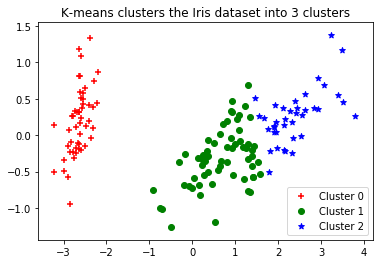

In [553]:
for i in range(0, pca_2d.shape[0]):
    if kmeans.labels_[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif kmeans.labels_[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif kmeans.labels_[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='*')
    
pl.legend([c1, c2, c3],['Cluster 0', 'Cluster 1', 'Cluster 2'])
pl.title('K-means clusters the Iris dataset into 3 clusters')
  
pl.show()

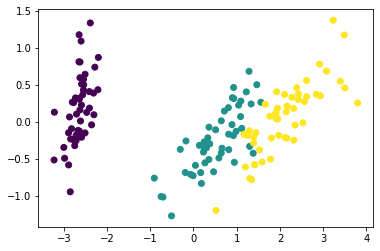

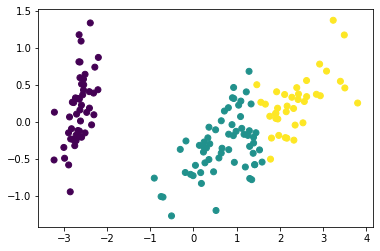

In [552]:

pl.figure('Toronto_merged')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=iris.target)
kmeans = KMeans(n_clusters=3, random_state=100)
kmeans.fit(iris.data)
pl.figure('K-means with 3 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
pl.show()

Now we want to see if there is any persian restaurant in our Toronto venue data

In [601]:
"Persian Restaurant" in Toronto_venues['Venue Category'].unique()


True

In [605]:
# showing the first ten rows only
pers = Toronto_grouped[["Neighborhood","Persian Restaurant"]]
pers.head(10) 

,Neighborhood,Persian Restaurant
0,Agincourt,0.0
1,"Alderwood, Long Branch",0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0
3,Bayview Village,0.0
4,"Bedford Park, Lawrence Manor East",0.0
5,Berczy Park,0.0
6,"Birch Cliff, Cliffside West",0.0
7,"Brockton, Parkdale Village, Exhibition Place",0.0
8,"Business reply mail Processing Centre, South C...",0.0
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.0


create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [609]:

# set number of clusters
kclusters = 3

Toronto_grouped_cluster = pers.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [613]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
Toronto_pers_merged = pers.copy()

# add clustering labels
Toronto_pers_merged ['Cluster Labels'] = kmeans.labels_

In [730]:
Toronto_pers_merged.head()

,Neighborhood,Persian Restaurant,Cluster Labels
0,Agincourt,0.0,1
1,"Alderwood, Long Branch",0.0,1
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,1
3,Bayview Village,0.0,1
4,"Bedford Park, Lawrence Manor East",0.0,1


merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood


In [706]:


To_pers_merged = Toronto_pers_merged.join(Toronto_new.set_index("Neighborhood"), on="Neighborhood")

print(To_pers_merged.shape)
To_pers_merged.head()

(3614, 9)


,Neighborhood,Persian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,1,43.7942,-79.262029,The Captain's Boil,43.788101,-79.265085,Seafood Restaurant
0,Agincourt,0.0,1,43.7942,-79.262029,Starbucks,43.783742,-79.253186,Coffee Shop
0,Agincourt,0.0,1,43.7942,-79.262029,Tim Hortons,43.798307,-79.272655,Coffee Shop
0,Agincourt,0.0,1,43.7942,-79.262029,Tim Hortons,43.791882,-79.249457,Coffee Shop
0,Agincourt,0.0,1,43.7942,-79.262029,Teriyaki Experience,43.783539,-79.253117,Japanese Restaurant


This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe


In [655]:
#Cluster 1

To_pers_merged1 = To_pers_merged.loc[To_pers_merged['Cluster Labels'] == 0, To_pers_merged.columns[[0, 1] + list(range(2, To_pers_merged.shape[1]))]]



To_pers_merged1.head()

,Neighborhood,Persian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
22,Don Mills,0.009709,0,43.745906,-79.352188,The Captain's Boil,43.754986,-79.349524,Seafood Restaurant
22,Don Mills,0.009709,0,43.725900,-79.340923,Aroma Espresso Bar,43.734400,-79.345204,Café
22,Don Mills,0.009709,0,43.745906,-79.352188,Baretto Caffé,43.744456,-79.346460,Café
22,Don Mills,0.009709,0,43.745906,-79.352188,Aroma Espresso Bar,43.734400,-79.345204,Café
22,Don Mills,0.009709,0,43.725900,-79.340923,Starbucks Reserve Bar,43.735764,-79.344156,Coffee Shop


In [654]:
To_pers_merged1.shape

(385, 9)

In [653]:
#Cluster2
To_pers_merged2 = To_pers_merged.loc[To_pers_merged['Cluster Labels'] == 1, To_pers_merged.columns[[0, 1] + list(range(2, To_pers_merged.shape[1]))]]



To_pers_merged2.head()

,Neighborhood,Persian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,1,43.7942,-79.262029,The Captain's Boil,43.788101,-79.265085,Seafood Restaurant
0,Agincourt,0.0,1,43.7942,-79.262029,Starbucks,43.783742,-79.253186,Coffee Shop
0,Agincourt,0.0,1,43.7942,-79.262029,Tim Hortons,43.798307,-79.272655,Coffee Shop
0,Agincourt,0.0,1,43.7942,-79.262029,Tim Hortons,43.791882,-79.249457,Coffee Shop
0,Agincourt,0.0,1,43.7942,-79.262029,Teriyaki Experience,43.783539,-79.253117,Japanese Restaurant


In [652]:
To_pers_merged2.shape

(3199, 9)

In [659]:
#Cluster2
To_pers_merged3 = To_pers_merged.loc[To_pers_merged['Cluster Labels'] == 2, To_pers_merged.columns[[0, 1] + list(range(2, To_pers_merged.shape[1]))]]



To_pers_merged3.shape

(30, 9)

In [682]:
To_pers_merged3.tail()

,Neighborhood,Persian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
97,"York Mills, Silver Hills",0.033333,2,43.75749,-79.374714,Sunshine Spot,43.770162,-79.374778,Breakfast Spot
97,"York Mills, Silver Hills",0.033333,2,43.75749,-79.374714,IKEA Bistro & Swedish Food Market,43.767763,-79.367451,Food & Drink Shop
97,"York Mills, Silver Hills",0.033333,2,43.75749,-79.374714,Tabüle,43.766556,-79.387950,Mediterranean Restaurant
97,"York Mills, Silver Hills",0.033333,2,43.75749,-79.374714,Pusateri's Fine Foods,43.768679,-79.384133,Gourmet Shop
97,"York Mills, Silver Hills",0.033333,2,43.75749,-79.374714,Shatter Abbas,43.769998,-79.374434,Persian Restaurant


<b><font size="4"> Discussion: 
<b><font size="4">

<b><font size="2">As we saw in the dataset,the most common venue types in downtown Toronto include coffeeshops, fastfood or pizza places, restaurants and especially Italian restaurants. There were only 7 Persian restaurants in downtown area which are mostly condenced in the second cluster.Cluster1 contains a limited area in which there are mostly asian and Japenese restaurant.
    
Through using Silhouette analysis, I built kmeans to show that there is a lot of similarity between neighborhoods and the most common restaurants contained within.In the other two clusters, cluster 2 and 3, as we see in the IRIS dataset,there is an overlap between the two clusters. The most of Restaurant venues we discovered in the most neighborhoods were similar and the greatest concentration of restaurants was in Central Toronto and downtown Toronto.So we can say that there are alot of restaurants in Toronto but the majority of them are located in the center of downtown Toronto.
 
As there are not too many Persian Cafes or restaurant in downtow Toronto, the optimum place to put a new Persian restaurant or a Persian cafe can be in Downtown Toronto as there are many Neighborhoods in the area but not too many competitions. So I can suggest my brother to consider oppening either a cafe or restaurant in downtown. <b><font size="2">

<b><font size="4"> Conclusion: 
<b><font size="4">

<b><font size="2">I feel confident enough to bring up this data I collected to my brother and disscuss the result with him. Also I am aware that by doing more work specially on the machin learning part I can get a better prediction on my results.Besides,  there could have been better results if I have access to more precise data of Persian restaurant or persian cafe.However, in near furture I will be working on gathering more data and considering on machine learning models to have get better and more accurate results.
    <b><font size="2">